In [1]:
import pandas as pd
import numpy as np

# Pulling the raw monthly factor returns data

In [2]:
starting_data = pd.read_csv('[world]_[all_themes]_[monthly]_[vw_cap].csv')

# EDA

In [3]:
starting_data.dtypes

location        object
name            object
freq            object
weighting       object
n_countries      int64
date            object
ret            float64
dtype: object

In [4]:
starting_data.head(2)

,location,name,freq,weighting,n_countries,date,ret
0,world,accruals,monthly,vw_cap,1,1946-01-31,0.018130
1,world,accruals,monthly,vw_cap,1,1946-02-28,-0.011203


In [5]:
starting_data['date'] = pd.to_datetime(starting_data['date'])

In [6]:
for col in starting_data.columns:
    print('Running for the column = ',col)
    print(len(starting_data[col].unique()))

Running for the column =  location
1
Running for the column =  name
13
Running for the column =  freq
1
Running for the column =  weighting
1
Running for the column =  n_countries
56
Running for the column =  date
1164
Running for the column =  ret
14477


In [7]:
starting_data = starting_data.drop(columns={'location','freq','weighting'})

In [8]:
starting_data.groupby('n_countries').count().head(5)

,name,date,ret
n_countries,,,
1,8110,8110,8110
2,599,599,599
4,206,206,206
5,16,16,16
6,5,5,5


In [9]:
sample_data = starting_data.query("n_countries == 1")
sample_data

,name,n_countries,date,ret
0,accruals,1,1946-01-31,0.018130
1,accruals,1,1946-02-28,-0.011203
2,accruals,1,1946-03-31,0.043073
3,accruals,1,1946-04-30,0.007563
4,accruals,1,1946-05-31,0.019484
...,...,...,...,...
13982,value,1,1981-10-31,-0.037265
13983,value,1,1981-11-30,0.022877
13984,value,1,1981-12-31,0.014329
13985,value,1,1982-01-31,0.018026


In [10]:
starting_universe = sample_data.pivot_table(index='date',columns='name',values='ret')

In [13]:
!pip install missingno

<AxesSubplot:>

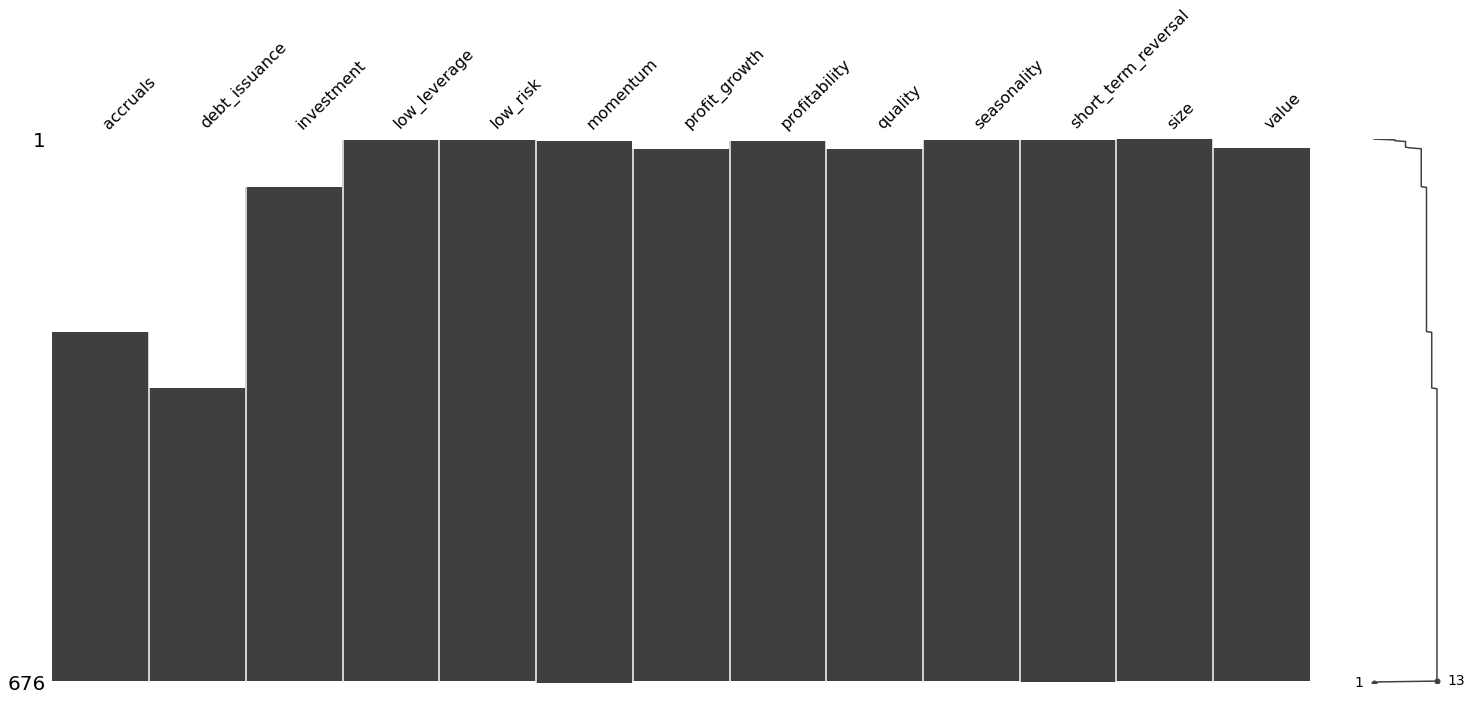

In [14]:
import missingno as msno
msno.matrix(starting_universe)

In [15]:
starting_universe.index.min()

Timestamp('1926-01-31 00:00:00')

In [16]:
starting_universe.index.max()

Timestamp('1982-04-30 00:00:00')

# Pulling the interest rate data

In [1]:
# !pip install yfinance

In [18]:
import yfinance as yf

In [19]:
interest_rate_data = yf.download('^TNX')['Adj Close']

[*********************100%%**********************]  1 of 1 completed


In [20]:
interest_rate_data

Date
1962-01-02    4.060
1962-01-03    4.030
1962-01-04    3.990
1962-01-05    4.020
1962-01-08    4.030
              ...  
2023-10-25    4.953
2023-10-26    4.845
2023-10-27    4.845
2023-10-30    4.875
2023-10-31    4.875
Name: Adj Close, Length: 15471, dtype: float64

In [21]:
starting_universe.columns

Index(['accruals', 'debt_issuance', 'investment', 'low_leverage', 'low_risk',
       'momentum', 'profit_growth', 'profitability', 'quality', 'seasonality',
       'short_term_reversal', 'size', 'value'],
      dtype='object', name='name')

In [22]:
sample_factor_list = ['momentum', 'profitability', 'quality','short_term_reversal', 'size', 'value']

In [23]:
starting_universe[sample_factor_list].dropna()

name,momentum,profitability,quality,short_term_reversal,size,value
date,,,,,,
1927-01-31,0.011616,-0.009928,-0.001837,-0.003510,0.011300,-0.004295
1927-02-28,-0.002105,0.005238,-0.028086,-0.004838,-0.004768,-0.016800
1927-03-31,0.034023,-0.011930,0.045026,-0.004404,-0.017351,0.013223
1927-04-30,0.027567,0.002745,0.023703,-0.017795,-0.014931,-0.005181
1927-05-31,0.036940,-0.001428,0.043191,-0.007053,-0.008950,-0.016030
...,...,...,...,...,...,...
1981-10-31,0.024638,0.028824,0.015927,-0.005999,-0.015191,-0.037265
1981-11-30,-0.006976,-0.010561,-0.016508,0.009393,0.002949,0.022877
1981-12-31,0.001474,0.000118,0.016338,0.007556,0.013478,0.014329


# Feature Engineering

In [24]:
def feature_engineering(df):
    # Copy the input DataFrame to avoid modifying the original data
    df_copy = df.copy()

    # Calculate lagged returns for each factor
    factor_columns = df_copy.columns
    for factor in factor_columns:
        df_copy[factor + '_lag1'] = df_copy[factor].shift(1)

    # Calculate rolling statistics for each factor
    for factor in factor_columns:
        df_copy[factor + '_rolling_mean'] = df_copy[factor].rolling(window=3).mean()
        df_copy[factor + '_rolling_std'] = df_copy[factor].rolling(window=3).std()

    # Create interaction features
    for i in range(len(factor_columns)):
        for j in range(i + 1, len(factor_columns)):
            factor1 = factor_columns[i]
            factor2 = factor_columns[j]
            df_copy[factor1 + '_' + factor2 + '_interaction'] = df_copy[factor1] * df_copy[factor2]

    # Calculate returns spread between two factors
    for i in range(len(factor_columns)):
        for j in range(i + 1, len(factor_columns)):
            factor1 = factor_columns[i]
            factor2 = factor_columns[j]
            df_copy[factor1 + '_' + factor2 + '_spread'] = df_copy[factor1] - df_copy[factor2]

    return df_copy

In [25]:
df_with_features = feature_engineering(starting_universe[sample_factor_list].dropna())

In [26]:
cleaned_df_with_features = df_with_features.shift(1).dropna()

In [27]:
factor_returns_df = df_with_features[sample_factor_list]
factor_returns_df

name,momentum,profitability,quality,short_term_reversal,size,value
date,,,,,,
1927-01-31,0.011616,-0.009928,-0.001837,-0.003510,0.011300,-0.004295
1927-02-28,-0.002105,0.005238,-0.028086,-0.004838,-0.004768,-0.016800
1927-03-31,0.034023,-0.011930,0.045026,-0.004404,-0.017351,0.013223
1927-04-30,0.027567,0.002745,0.023703,-0.017795,-0.014931,-0.005181
1927-05-31,0.036940,-0.001428,0.043191,-0.007053,-0.008950,-0.016030
...,...,...,...,...,...,...
1981-10-31,0.024638,0.028824,0.015927,-0.005999,-0.015191,-0.037265
1981-11-30,-0.006976,-0.010561,-0.016508,0.009393,0.002949,0.022877
1981-12-31,0.001474,0.000118,0.016338,0.007556,0.013478,0.014329


In [28]:
factor_returns_df.isnull().sum()

name
momentum               0
profitability          0
quality                0
short_term_reversal    0
size                   0
value                  0
dtype: int64

# Curating the Target Weights 

In [29]:
# weight_vector = factor_returns_df.apply(lambda x: abs(x))
weight_vector = factor_returns_df.applymap(lambda x: abs(x) if x >= 0 else 1/abs(x))
weight_vector

name,momentum,profitability,quality,short_term_reversal,size,value
date,,,,,,
1927-01-31,0.011616,100.728988,544.325141,284.940301,0.011300,232.807493
1927-02-28,475.015574,0.005238,35.604834,206.679370,209.749609,59.522895
1927-03-31,0.034023,83.824884,0.045026,227.048787,57.633043,0.013223
1927-04-30,0.027567,0.002745,0.023703,56.196576,66.975374,193.000614
1927-05-31,0.036940,700.199882,0.043191,141.787531,111.737102,62.384155
...,...,...,...,...,...,...
1981-10-31,0.024638,0.028824,0.015927,166.707579,65.828001,26.834500
1981-11-30,143.340715,94.687394,60.577977,0.009393,0.002949,0.022877
1981-12-31,0.001474,0.000118,0.016338,0.007556,0.013478,0.014329


In [30]:
# Normalize each weight vector to sum to 1
normalized_weight_vectors = weight_vector.T / weight_vector.T.sum()
normalized_weight_vectors = normalized_weight_vectors.T

In [31]:
normalized_weight_vectors.head(5)

name,momentum,profitability,quality,short_term_reversal,size,value
date,,,,,,
1927-01-31,0.000010,0.086624,0.468106,0.245041,0.000010,0.200209
1927-02-28,0.481478,0.000005,0.036089,0.209491,0.212603,0.060333
1927-03-31,0.000092,0.227415,0.000122,0.615978,0.156357,0.000036
1927-04-30,0.000087,0.000009,0.000075,0.177710,0.211796,0.610324
1927-05-31,0.000036,0.689045,0.000043,0.139529,0.109957,0.061390


In [32]:
df_with_features.head(5)

name,momentum,profitability,quality,short_term_reversal,size,value,momentum_lag1,profitability_lag1,quality_lag1,short_term_reversal_lag1,...,profitability_quality_spread,profitability_short_term_reversal_spread,profitability_size_spread,profitability_value_spread,quality_short_term_reversal_spread,quality_size_spread,quality_value_spread,short_term_reversal_size_spread,short_term_reversal_value_spread,size_value_spread
date,,,,,,,,,,,,,,,,,,,,,
1927-01-31,0.011616,-0.009928,-0.001837,-0.003510,0.011300,-0.004295,NaN,NaN,NaN,NaN,...,-0.008090,-0.006418,-0.021228,-0.005632,0.001672,-0.013137,0.002458,-0.014810,0.000786,0.015596
1927-02-28,-0.002105,0.005238,-0.028086,-0.004838,-0.004768,-0.016800,0.011616,-0.009928,-0.001837,-0.003510,...,0.033324,0.010077,0.010006,0.022039,-0.023248,-0.023318,-0.011286,-0.000071,0.011962,0.012033
1927-03-31,0.034023,-0.011930,0.045026,-0.004404,-0.017351,0.013223,-0.002105,0.005238,-0.028086,-0.004838,...,-0.056955,-0.007525,0.005422,-0.025153,0.049430,0.062377,0.031802,0.012947,-0.017627,-0.030574
1927-04-30,0.027567,0.002745,0.023703,-0.017795,-0.014931,-0.005181,0.034023,-0.011930,0.045026,-0.004404,...,-0.020957,0.020540,0.017676,0.007927,0.041498,0.038634,0.028884,-0.002864,-0.012613,-0.009750
1927-05-31,0.036940,-0.001428,0.043191,-0.007053,-0.008950,-0.016030,0.027567,0.002745,0.023703,-0.017795,...,-0.044619,0.005625,0.007521,0.014602,0.050244,0.052141,0.059221,0.001897,0.008977,0.007080


In [33]:
cleaned_df_with_features.columns

Index(['momentum', 'profitability', 'quality', 'short_term_reversal', 'size',
       'value', 'momentum_lag1', 'profitability_lag1', 'quality_lag1',
       'short_term_reversal_lag1', 'size_lag1', 'value_lag1',
       'momentum_rolling_mean', 'momentum_rolling_std',
       'profitability_rolling_mean', 'profitability_rolling_std',
       'quality_rolling_mean', 'quality_rolling_std',
       'short_term_reversal_rolling_mean', 'short_term_reversal_rolling_std',
       'size_rolling_mean', 'size_rolling_std', 'value_rolling_mean',
       'value_rolling_std', 'momentum_profitability_interaction',
       'momentum_quality_interaction',
       'momentum_short_term_reversal_interaction', 'momentum_size_interaction',
       'momentum_value_interaction', 'profitability_quality_interaction',
       'profitability_short_term_reversal_interaction',
       'profitability_size_interaction', 'profitability_value_interaction',
       'quality_short_term_reversal_interaction', 'quality_size_interactio

In [34]:
normalized_weight_vectors.columns

Index(['momentum', 'profitability', 'quality', 'short_term_reversal', 'size',
       'value'],
      dtype='object', name='name')

# Final Data Sets

In [35]:
normalized_weight_vectors.to_csv("normalized_weight_vectors.csv")  
cleaned_df_with_features.to_csv("cleaned_df_with_features.csv")